In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from non_linearity.environment import Particle
from non_linearity.simulation import simulation
from scipy import signal as sn

In [37]:
freq = 81.5e3
omega = 2*np.pi*freq
T = 1 / freq
max_time = 1600 * T
delta_t = T / 400
N_time = int(max_time / delta_t)
# psd_stamps = int(N_time / 2 + 1)
t = np.linspace(0, max_time, int(N_time))
gamma = 65e3

In [38]:
env = Particle(omega, gamma, radius=73e-9)

In [39]:
100*T, (T/4)/delta_t

(0.001226993865030675, 100.0)

In [40]:
env.thermal_force_std

4413218.95448856

In [56]:
M = 150
cubic_delayed = {i: [None] for i in range(0, 410, 10)}
for key in cubic_delayed.keys():
    cubic = np.zeros(shape=(M, N_time))
    for i in tqdm(range(M)):
        data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, 5.9e5*(env.zp_x**3/env.zp_p), key)
        data = np.array(data)
        cubic[i, :] = data
    cubic_delayed[key] = cubic

100%|██████████| 150/150 [00:07<00:00, 20.11it/s]


In [57]:
M = 150
neg_cubic_delayed = {i: [None] for i in range(0, 410, 10)}
for key in neg_cubic_delayed.keys():
    cubic = np.zeros(shape=(M, N_time))
    for i in tqdm(range(M)):
        data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, -5.9e5*(env.zp_x**3/env.zp_p), key)
        data = np.array(data)
        cubic[i, :] = data
    neg_cubic_delayed[key] = cubic

 50%|█████     | 75/150 [00:03<00:03, 21.56it/s]

: 

: 

In [42]:
M = 100
reference = np.zeros(shape=(M, N_time))

for i in tqdm(range(M)):
    data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, 0, 0)
    data = np.array(data)
    reference[i, :] = data

  2%|▏         | 2/100 [00:00<00:06, 15.99it/s]

100%|██████████| 100/100 [00:04<00:00, 21.70it/s]


In [44]:
def psd(traces, delta_t):
    pxxs = []
    for i in range(traces.shape[0]):
        freq, pxx = sn.welch(traces[i,:], fs=1/delta_t, window='hamming', nperseg=int(traces.shape[1]/2))
        if not np.isnan(pxx.max()) and not pxx.max()>1e12:
            pxxs.append(pxx)
    return freq, np.array(pxxs).mean(axis=0)

In [45]:
#psds = psd_batches('../data/traces/simulation/references', delta_t)
#areas = compute_area(psds)

In [46]:
#plt.semilogy(np.array(psds['power']).mean(axis=0))
#plt.xlim([1e2, 1e3])

In [50]:
#freq, pxx = psd(states, delta_t)
#freq, pxx = psd(states, delta_t)
#freq, pxx = psd(reference, delta_t)
#plt.semilogy(freq_c, np.array(psds['power']).mean(axis=0))
#for i in range(100):
#    freq, pxx = sn.welch(storage[i,:], fs=1/delta_t, window='hamming', nperseg=int(storage.shape[1]/2))
#    print(np.isnan(pxx.max()))

#damped_pxxs = {i: []for i in range(0, 300, 100)}
#for i in damped_pxxs.keys():
#    freq_d, damped_pxx = psd(damped_delays[i], delta_t)
#    damped_pxxs[i] = {'freq': freq_d, 'psd': damped_pxx}
#    plt.semilogy(freq_d, damped_pxx)
#plt.semilogy(freq, pxx)
#plt.semilogy(freq, pxx)

#for key in list(cubic_delayed.keys())[::10]:
##    freq, pxx = psd(cubic_delayed[key], delta_t)
 #   plt.semilogy(freq, pxx)
#plt.semilogy(freq_d, damped_pxx)

#plt.legend(['Without Feedback','Cubic-Damped', 'Damped'])
#plt.xlim([3e4, 1.2e5])
#plt.ylim([1e1, 1e6])

In [51]:
ref_psd = psd(reference, delta_t)[1].sum()
delay_areas = []
for key in list(cubic_delayed.keys()):
    freq, pxx = psd(cubic_delayed[key], delta_t)
    delay_areas.append(pxx.sum())

delay_areas = np.array(delay_areas)
non_nan_indexes = ~np.isnan(np.array(delay_areas))
delay_areas = delay_areas[non_nan_indexes]
delays = np.array(list(cubic_delayed.keys()))[non_nan_indexes]*delta_t

In [52]:
def autocor_0(t, omega, gamma, m= 3.368e-18):
    kb = 1.3806e-23
    T = 293
    C = 2*(gamma*kb*T/m)
    
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    T0 = C*np.exp(-gamma*t/2)*(2*Omega*np.cos(Omega*t)+gamma*np.sin(Omega*t))/(4*gamma*Omega*(omega**2))
    return T0


def autocor_perturbation(t, omega, gamma, b, tau, m= 3.368e-18):
    kb = 1.3806e-23
    T = 293
    T0 = autocor_0(t, omega, gamma, m=m)
    C = 2*(gamma*kb*T/m) 
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    mult = np.exp(-gamma*t/2)/(64*(gamma**3)*(Omega**4)*(omega**6))
    part1 = np.exp(gamma*tau/2)*(8*gamma*(Omega**4)-4*(omega**2)*(gamma**2)*(Omega**2)*(t-tau))*np.cos(Omega*(t-tau))
    
    part2 = Omega*np.exp(gamma*tau/2)*(8*gamma*(Omega**2)*(omega**2)*(t-tau)+\
                                       8*(Omega**4)+4*(gamma**2)*(omega**2)+6*(gamma**2)*(Omega**2))*np.sin(Omega*(t-tau))
    part3 = np.exp(-gamma*tau/2)*(Omega**2)*(2*Omega*(gamma**2)-8*(Omega**3))*np.sin(Omega*(t+tau))
    part4 = np.exp(-gamma*tau/2)*8*gamma*(Omega**4)*np.cos(Omega*(t+tau))
    T1 = -3*C*C*b*mult*(part1+part2+part3+part4)
    return T0+T1

def theoretical_area_frac(omega, gamma, gain, delay, m=3.368e-18):
    T0 = autocor_0(0, omega, gamma, m=m)
    T1 = autocor_perturbation(0, omega, gamma, gain, delay, m=m)
    return T1/T0

In [53]:
theory_delays = np.linspace(0, T, 100)
areas_t = theoretical_area_frac(env.__omega__, env.__gamma__, -5e5/env._m_, theory_delays, m=env._m_)

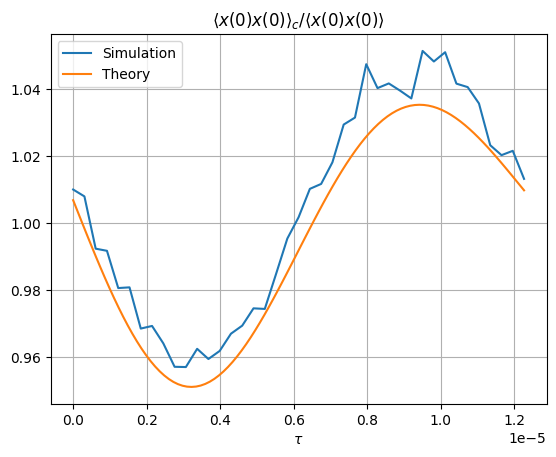

In [55]:
plt.plot(delays, np.array(delay_areas)/ref_psd)
plt.plot(theory_delays, areas_t)
plt.legend(['Simulation', 'Theory'])
plt.xlabel(r'$\tau$')
plt.title(r'$\langle x(0)x(0)\rangle_{c}/\langle x(0)x(0)\rangle$')
#plt.ylim([0,2])
plt.grid()
#damped_pxxs.keys()